In [ ]:
# Potrzebne biblioteki
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from os import rename
import re

In [ ]:
!pip install catboost

In [ ]:
# Dodanie naszej zescrapowanej bazy danych z dodaną kolumną określającą gatunek
dane_pieski_i_kotki = pd.read_csv("dane_cale.csv")

dane_pieski_i_kotki.index = dane_pieski_i_kotki.index + 1
df_dane_pieski_i_kotki = pd.DataFrame(dane_pieski_i_kotki)

df_dane_pieski_i_kotki

,name,opis,rasa,wiek,płeć,waga,numer,status,przyjęty,wydany,znaleziony,zdjecie,gatunek
1,Brak nazwy,Tak wygląda złamane psie serce...przed Wami Ra...,Mieszaniec,10 lat,samiec,19 kg,1213/24,wydane adopcja,2024-08-23,2024-12-11,NaN,image_1.jpg,pies
2,Brak nazwy,NaN,Bernardyn,6 miesięcy,samiec,38 kg,1706/24,wydane odbiór,2024-12-10,2024-12-11,"Warszawa, skrzyżowanie Al. Krakowskiej/ Na Skraju",image_2.jpg,pies
3,Brak nazwy,Rita jest z nami od niedawna. Pierwsze dni w s...,Owczarek niemiecki,5 lat,samica,30 kg,1123/24,wydane adopcja,2024-08-01,2024-12-11,"Warszawa, ul Ogrodowa",image_3.jpg,pies
4,Brak nazwy,Raja trafiła do nas skrajnie wychudzony i zani...,Mieszaniec,14 lat,samica,17 kg,1389/24,wydane adopcja,2024-10-03,2024-12-10,"Warszawa, ul. Srebrna",image_4.jpg,pies
5,Brak nazwy,NaN,Mieszaniec,9 miesięcy,samiec,11 kg,1683/24,wydane odbiór,2024-12-06,2024-12-10,"Warszawa, ul. Korkowa",image_5.jpg,pies
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5996,Brak nazwy,"Romcio to młody 8-miesięczny, wesoły burasek. ...",Europejska,2 lata,samiec,2 kg,1206/22,wydane adopcja,2022-11-03,2022-11-27,"aleja Komandosów, Warszawa",image_6056.jpg,kot
5997,Brak nazwy,Tego kota możecie poznać w punkcie Ochota na K...,Europejska,5 lat,samica,3 kg,1234/22,wydane adopcja,2022-11-08,2022-11-27,"Warszawa, ul. Bakalarska",image_6057.jpg,pies
5998,Brak nazwy,NaN,Europejska,2 lata,samica,1 kg,1289/22,wydane adopcja,2022-11-22,2022-11-27,Porzucony pod schroniskiem,image_6058.jpg,pies
5999,Brak nazwy,"Arya to średniej wielkości, energiczna i łagod...",Mieszaniec,3 lata,samica,17 kg,1075/22,wydane adopcja,2022-06-28,2022-11-26,"Warszawa, ul Płocka",image_6059.jpg,pies


In [ ]:
# Dla większej dokładności przypisania gatunku zmieniamy gatunek w zależności od znalezienia określonych zwrotów w opisie zwierzęcia
lista_psia = [r"pies", r"psi", r"psiu", r"szczeni", "psy", r"suni"]
lista_kocia = [r"kot", r"koci", r"kici"]

lista_wykluczajace_kot = ["nie lubi kotów"]
lista_wykluczajace_pies = [r"piesz"]

def contains_whole_word(text, word_list, exclude_list=[]):
    # Sprawdzanie wykluczających fraz
    if any(re.search(rf"\b{word}(?=\s|$)", text) for word in exclude_list):
        return False
    # Dopasowanie całych słów
    return any(re.search(rf"\b{word}(?=\s|$)", text) for word in word_list)

# Aktualizacja kolumny "gatunek" dla psów
df_dane_pieski_i_kotki["gatunek"] = df_dane_pieski_i_kotki.apply(
    lambda row: "pies" if pd.notna(row["opis"]) and contains_whole_word(str(row["opis"]), lista_psia, lista_wykluczajace_pies) else row["gatunek"],
    axis=1
)

# Aktualizacja kolumny "gatunek" dla kotów
df_dane_pieski_i_kotki["gatunek"] = df_dane_pieski_i_kotki.apply(
    lambda row: "kot" if pd.notna(row["opis"]) and contains_whole_word(str(row["opis"]), lista_kocia, lista_wykluczajace_kot) else row["gatunek"],
    axis=1
)

In [ ]:
# Zmiana na małe litery
df_dane_pieski_i_kotki["rasa"] = df_dane_pieski_i_kotki["rasa"].str.lower()

In [ ]:
# Dla większej dokładności przypisania gatunku zmieniamy gatunek na podstawie ras występujących w bazie danych
# Dla kotów, ponieważ większość zwierząt została rozpoznana jako psy
rasy_kotow = [
    "syberyjski", "mix ragdoll", "ragdoll", "chausie", "syryjski",
    "norweski leśny", "selkirk rf", "syjamski", "europejska", "devon rex",
    "rosyjski niebieski", "święty kot birmański", "sfinks",
    "szkocki zwisłouchy", "bengalski", "abisyński", "perski"
]

df_dane_pieski_i_kotki["gatunek"] = df_dane_pieski_i_kotki.apply(
    lambda row: "kot" if row["rasa"] in rasy_kotow else row["gatunek"],
    axis=1
)

In [ ]:
# Usunięcie występujących pojedynczo innych gatunków zwierząt z bazy danych
lista_do_wyrzucenia =  [
    "królik", "mysz domowa", "królik miniaturowy",
    "mix jagdtf", "fuzzy", "skinny", "rozetka",
    "dżungarski", "peruwianka",
    "mix ast", "myszoskoczek",
    "ratatuj", "mix buld", "szynszyla",
]

df_dane_pieski_i_kotki = df_dane_pieski_i_kotki[~df_dane_pieski_i_kotki["rasa"].isin(lista_do_wyrzucenia)].reset_index(drop = True)

In [ ]:
df_dane_pieski_i_kotki["gatunek"].value_counts()

,count
gatunek,
pies,3696
kot,2227


In [ ]:
# Usunięcie zbędnych kolumn z bazy danych
do_wyrzucenia = ["name", "numer", "status", "znaleziony"]
dane = df_dane_pieski_i_kotki.drop(columns = do_wyrzucenia)

In [ ]:
# Wyciągnięcie liczby i jednostki z kolumny wiek i utworzenie nowych kolumn z tymi wartościami
dane[['wiek_liczba', 'wiek_jednostka']] = dane['wiek'].str.extract(r'(\d+)\s*(\w+)')
dane['wiek_liczba'] = dane['wiek_liczba'].astype(int)

# Analogicznie dla wagi
dane[['waga_kg', 'waga_jednostka']] = dane['waga'].str.extract(r'(\d+)\s*(\w+)')
dane['waga_kg'] = dane['waga_kg'].astype(int)

In [ ]:
# Ujednolicenie jednostki i dodanie nowej kolumny z tą wartością
def przelicz_wiek(row):
    if row["wiek_jednostka"] in ["rok", "lat", "lata"]:
        return row["wiek_liczba"] * 12
    return row["wiek_liczba"]

dane["wiek_liczba_prawidłowa"] = dane.apply(przelicz_wiek, axis = 1)

In [ ]:
# Usunięcie zbędnych kolumn
do_wyrzucenia = ["wiek", "wiek_liczba", "wiek_jednostka"]
dane = dane.drop(columns = do_wyrzucenia)

In [ ]:
# Obliczenie czasu pobytu zwierzęcia w schronisku w dniach i dodanie nowej kolumny z tą wartością
dane["przyjęty"] = pd.to_datetime(dane["przyjęty"])
dane["wydany"] = pd.to_datetime(dane["wydany"])

dane["czas_pobytu"] = (dane["wydany"] - dane["przyjęty"]).dt.days

In [ ]:
# Usunięcie zbędnych kolumn
do_wyrzucenia = ["waga", "przyjęty", "wydany", "waga_jednostka", "zdjecie"]
dane = dane.drop(columns = do_wyrzucenia)

In [ ]:
# Zmiana nazw kolumn
dane = dane.rename(columns={"wiek_liczba_prawidłowa": "wiek_miesiące", "czas_pobytu": "czas_pobytu_dni"})

In [ ]:
# Pustym wartościom przypisujemy wybrane wartości dla wygody
dane["opis"] = dane["opis"].fillna("Brak opisu").astype(str)

dane["czas_pobytu_dni"] = dane["czas_pobytu_dni"].fillna(0).astype(int)

# Zmiana liter w rasach na małe
dane["rasa"] = dane["rasa"].str.lower()

In [ ]:
# Definicja słów kluczowych dla kategorii
# Kategorie opisują cechy zwierząt
kategorie = {
    "przyjazny": [r"przyjazn", r"łagodn", "kocha ludzi", "uwielbia zabawę", r"przytul", r"merda", r"szczęśliw", r"liz", "wita", r"grzeczn", r"delikatn"],
    "agresywny": [r"agresyw", r"dominując", "wymaga doświadczonego opiekuna", r"niebezpieczn", r"gryz", r"atak"],
    "chory": [r"chor", r"choroba", "wymaga leczenia", "opieka weterynaryjna", r"lek", "choruje na", r"niepełnosprawn", r"ślep", r"zmęczon", r"cierp"],
    "bojący się": ["boi się", r"wycofan", r"strachliw", r"nieśmiał", "na dystans", "chowa się", "trzęsie się", "piszczy", "kuli ogon"],
    "aktywny": [r"aktywn", "biega", "sportowiec", "pełen energii", r"energi", "zabawa", r"bawi"]
}

# Funkcja przypisująca kategorię na podstawie opisu
def przypisz_kategorie(opis):
    kategorie_zwierze = []
    for kategoria, slowa_kluczowe in kategorie.items():
        if any(slowo in opis.lower() for slowo in slowa_kluczowe):  # Dopasowanie słów kluczowych
            kategorie_zwierze.append(kategoria)
    return ", ".join(kategorie_zwierze) if kategorie_zwierze else "niezidentyfikowany"

# Tworzenie nowej kolumny z kategoriami
dane["kategoria"] = dane["opis"].apply(przypisz_kategorie)

dane["kategoria"].value_counts()

,count
kategoria,
niezidentyfikowany,2787
przyjazny,778
"przyjazny, aktywny",505
aktywny,364
"przyjazny, chory",257
"przyjazny, chory, aktywny",224
chory,172
"przyjazny, bojący się",152
"chory, aktywny",108


In [ ]:
# Iteracja po nazwach kategorii i dodanie nowych kolumn
for kategoria in kategorie.keys():
    dane[kategoria] = dane["kategoria"].apply(lambda x: 1 if kategoria in x else 0)

In [ ]:
#dane.to_csv('czyste_dane.csv', index = False)

In [ ]:
dane

,opis,rasa,płeć,gatunek,waga_kg,wiek_miesiące,czas_pobytu_dni,kategoria,przyjazny,agresywny,chory,bojący się,aktywny
0,Tak wygląda złamane psie serce...przed Wami Ra...,mieszaniec,samiec,pies,19,120,110,"agresywny, chory",0,1,1,0,0
1,Brak opisu,bernardyn,samiec,pies,38,6,1,niezidentyfikowany,0,0,0,0,0
2,Rita jest z nami od niedawna. Pierwsze dni w s...,owczarek niemiecki,samica,pies,30,60,132,"przyjazny, chory, bojący się, aktywny",1,0,1,1,1
3,Raja trafiła do nas skrajnie wychudzony i zani...,mieszaniec,samica,pies,17,168,68,przyjazny,1,0,0,0,0
4,Brak opisu,mieszaniec,samiec,pies,11,9,4,niezidentyfikowany,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5918,"Romcio to młody 8-miesięczny, wesoły burasek. ...",europejska,samiec,kot,2,24,24,"chory, aktywny",0,0,1,0,1
5919,Tego kota możecie poznać w punkcie Ochota na K...,europejska,samica,kot,3,60,19,przyjazny,1,0,0,0,0
5920,Brak opisu,europejska,samica,kot,1,24,5,niezidentyfikowany,0,0,0,0,0
5921,"Arya to średniej wielkości, energiczna i łagod...",mieszaniec,samica,pies,17,36,151,"przyjazny, aktywny",1,0,0,0,1


In [ ]:
# Usunięcie zbędnych kolumn
df_do_modelu = dane.drop(columns=["kategoria", "opis"])

In [ ]:
# Utworzenie osobnych kolumn dla każdej z kategorii, dla działania modelu i przypisanie wierszom
# odpowiednio 0 i 1 gdy dana kategoria nie występuje lub występuje
df_do_modelu["przyjazny"] = df_do_modelu["przyjazny"].astype("category")
df_do_modelu["agresywny"] = df_do_modelu["agresywny"].astype("category")
df_do_modelu["chory"] = df_do_modelu["chory"].astype("category")
df_do_modelu["bojący się"] = df_do_modelu["bojący się"].astype("category")
df_do_modelu["aktywny"] = df_do_modelu["aktywny"].astype("category")

NameError: name 'df_do_modelu' is not defined

In [ ]:
# Podobnie dla rasy, płci i gatunku, ale tutaj wartościami będzie False i True
df_do_modelu = pd.get_dummies(df_do_modelu, columns = ["rasa", "płeć", "gatunek"], drop_first = True)

In [ ]:
# Przesunięcie kolumny z czasem pobytu na sam koniec
kolumny = [kol for kol in df_do_modelu.columns if kol != "czas_pobytu_dni"]
kolumny.append("czas_pobytu_dni")

df_do_modelu = df_do_modelu[kolumny]

In [ ]:
# Pobranie danych gotowych do użycia modelu w streamlit
df_do_modelu.to_csv('te_dane.csv', index = False)
df_do_modelu

,waga_kg,wiek_miesiące,przyjazny,agresywny,chory,bojący się,aktywny,rasa_akita inu,rasa_amstaff,rasa_amstaff/pitbull,...,rasa_wyżeł,rasa_wyżeł fran,rasa_wyżeł weimarski,rasa_yorkshire terier,rasa_łajka,rasa_święty kot birmański,płeć_samica,płeć_samiec,gatunek_pies,czas_pobytu_dni
0,19,120,0,1,1,0,0,False,False,False,...,False,False,False,False,False,False,False,True,True,110
1,38,6,0,0,0,0,0,False,False,False,...,False,False,False,False,False,False,False,True,True,1
2,30,60,1,0,1,1,1,False,False,False,...,False,False,False,False,False,False,True,False,True,132
3,17,168,1,0,0,0,0,False,False,False,...,False,False,False,False,False,False,True,False,True,68
4,11,9,0,0,0,0,0,False,False,False,...,False,False,False,False,False,False,False,True,True,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5918,2,24,0,0,1,0,1,False,False,False,...,False,False,False,False,False,False,False,True,False,24
5919,3,60,1,0,0,0,0,False,False,False,...,False,False,False,False,False,False,True,False,False,19
5920,1,24,0,0,0,0,0,False,False,False,...,False,False,False,False,False,False,True,False,False,5
5921,17,36,1,0,0,0,1,False,False,False,...,False,False,False,False,False,False,True,False,True,151


In [ ]:
# Podział bazy danych na zbiór uczący i testowy
 (train_set, test_set) = train_test_split(df_do_modelu, train_size = 0.7, random_state = 13)

print('Train size:', train_set.shape[0])
print('Test size:', test_set.shape[0])

Train size: 4146
Test size: 1777


In [ ]:
# Liczba kolumn
liczba_kolumn = len(df_do_modelu.columns)

In [ ]:
# Podział kolumn na zmienne objaśniające i zmienną objaśnianą (w naszym przypadku czas pobytu zwierzęcia w schronisku)
train_inputs = train_set.iloc[:, 0:(liczba_kolumn - 1)]
train_days = train_set.iloc[:, (liczba_kolumn - 1)]
test_inputs = test_set.iloc[:, 0:(liczba_kolumn - 1)]
test_days = test_set.iloc[:, (liczba_kolumn - 1)]

## SZUKANIE NAJLEPSZEGO MODELU

# RANDOM FOREST

In [ ]:
# Stworzenie wielu kombinacji do wybrania najlepszych parametrów
model = RandomForestRegressor(random_state = 13)

param_grid = {
    'max_depth': [5, 10, 15, 20, None],  # Możliwe wartości max_depth
    'n_estimators': [50, 100, 200, 300],  # Liczba drzew w lesie
    'random_state': [13, 42, 123]  # Testowanie kilku różnych random_state
}

grid_search = GridSearchCV(estimator = model, param_grid=param_grid, cv = 5, scoring = 'r2', verbose = 2)

# Dopasowanie modelu do danych
grid_search.fit(train_inputs, train_days)

# Wyświetlenie najlepszych parametrów i wyniku
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepsze R²:", grid_search.best_score_)

In [ ]:
# Model z najlepszymi parametrami
model1 = RandomForestRegressor(max_depth = 5, random_state = 13, n_estimators = 50)

model1.fit(train_inputs, train_days)

RandomForestRegressor(max_depth=5, n_estimators=50, random_state=13)

In [ ]:
# Dopasowanie modelu
model1.score(test_inputs, test_days)

0.3378251258255065

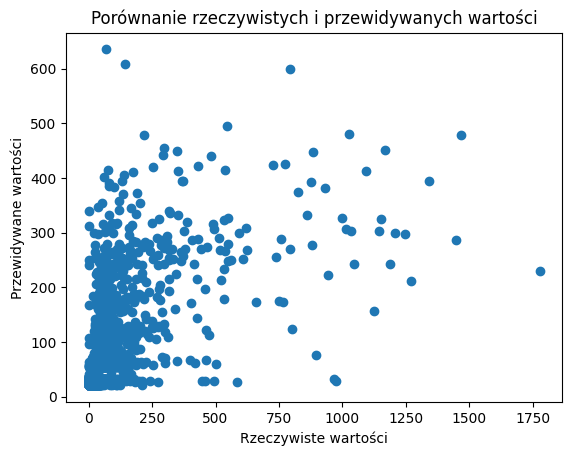

In [ ]:
# Sprawdzenie dopasowania na wykresie
import matplotlib.pyplot as plt

preds = model1.predict(test_inputs)
plt.scatter(test_days, preds)
plt.xlabel("Rzeczywiste wartości")
plt.ylabel("Przewidywane wartości")
plt.title("Porównanie rzeczywistych i przewidywanych wartości")
plt.show()

# CATBOOST

In [ ]:
from catboost import CatBoostRegressor

cat_features = ["przyjazny", "agresywny", "chory", "bojący się", "aktywny"]

# Tworzenie modelu CatBoost
catboost_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=100
)

# Dopasowanie modelu z uwzględnieniem cech kategorycznych
catboost_model.fit(
    train_inputs, train_days,
    cat_features=cat_features
)

# Wynik na zbiorze testowym
print("CatBoost R² na zbiorze testowym:", catboost_model.score(test_inputs, test_days))

0:	learn: 194.0696338	total: 48.1ms	remaining: 24s
100:	learn: 149.6902676	total: 446ms	remaining: 1.76s
200:	learn: 136.6765095	total: 862ms	remaining: 1.28s
300:	learn: 129.7339735	total: 1.15s	remaining: 761ms
400:	learn: 124.3255064	total: 1.57s	remaining: 389ms
499:	learn: 119.6503153	total: 1.86s	remaining: 0us
CatBoost R² na zbiorze testowym: 0.3233717707711843


# SIECI NEURONOWE

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import r2_score

# Konwersja danych na float32
train_inputs = train_inputs.astype(np.float32)
test_inputs = test_inputs.astype(np.float32)
train_days = train_days.astype(np.float32)
test_days = test_days.astype(np.float32)

# Tworzenie modelu sieci neuronowej
model_nn = Sequential([
    Dense(128, activation='relu', input_dim=train_inputs.shape[1]),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')  # Wyjście regresyjne
])

# Kompilacja modelu
model_nn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Trenowanie modelu
model_nn.fit(train_inputs, train_days, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Ocena modelu
nn_preds = model_nn.predict(test_inputs)

r2_score(test_days, nn_preds)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 33057.0938 - mae: 80.9147 - val_loss: 71246.9453 - val_mae: 104.8135
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 28576.7012 - mae: 80.5110 - val_loss: 69594.7031 - val_mae: 103.9748
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 27937.7598 - mae: 81.1695 - val_loss: 69021.5312 - val_mae: 99.8648
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24472.7129 - mae: 78.1807 - val_loss: 67815.6562 - val_mae: 98.6562
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27359.1230 - mae: 81.3668 - val_loss: 67107.4297 - val_mae: 95.0605
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24667.5801 - mae: 77.9652 - val_loss: 65743.5547 - val_mae: 95.6886
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 23141.6602 - mae: 76.2011 - val_loss: 65705.5000 - val_mae: 92.5000
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28323.4570 - mae: 78.7468 - val_loss: 64817.8398 - va

0.3328673243522644

# Dla wybranego modelu - random forest

In [ ]:
predictions = model1.predict(test_inputs)

# Mean absolute error dla wybranego modelu (błąd jaki przyjmujemy)
print(round(mean_absolute_error(test_days, predictions), 2))

64.96


In [ ]:
# Wartości różnic pomiędzy faktycznymi
differences = predictions - test_days
differences.name = 'różnica'
differences

,różnica
1401,36.712036
5737,12.971061
213,23.112092
1351,-132.955609
1813,4.095338
...,...
5886,111.141473
694,-106.330855
2045,132.308429
4809,102.721383


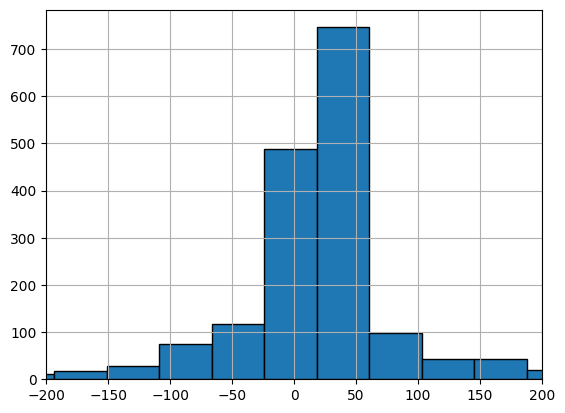

In [ ]:
import matplotlib.pyplot as plt

# Tworzenie histogramu dla różnic
differences.hist(bins=50, edgecolor='k')
plt.xlim(-200, 200)
plt.show()

Predykcje są większe niż wartości rzeczywiste

# Pytania

In [ ]:
# gatunek = input("Jakiego gatunku jest zwierzę? Wpisz 'pies' lub 'kot'. ")
# płeć = input("Jakiej płci jest zwierzę? Wpisz 'samiec' lub samica'. ")
# rasa = input("Jakiej rasy jest zwierzę? Jeżeli żadnej, wpisz 'mieszaniec'. ")
# wiek = int(input("Ile miesięcy ma zwierzę? "))
# waga = int(input("Ile kilogramów waży zwierzę? Podaj liczbę całkowitą. "))
# przyjazny = int(input("Czy zwierzę jest przyjazne? Wpisz 0 jeśli nie lub 1 jeśli tak. "))
# agresywny	= int(input("Czy zwierzę jest agresywne? Wpisz 0 jeśli nie lub 1 jeśli tak. "))
# chory	= int(input("Czy zwierzę jest chore? Wpisz 0 jeśli nie lub 1 jeśli tak. "))
# bojący_się	= int(input("Czy zwierzę jest strachliwe? Wpisz 0 jeśli nie lub 1 jeśli tak. "))
# aktywny = int(input("Czy zwierzę jest aktywne? Wpisz 0 jeśli nie lub 1 jeśli tak. "))

In [ ]:
# data = [
#     {'gatunek': gatunek, 'rasa': rasa, 'płeć': płeć, 'wiek_miesiące': wiek, 'waga_kg': waga,
#      'przyjazny': przyjazny,	'agresywny': agresywny,	'chory': chory,	'bojący się': bojący_się,	'aktywny': aktywny}
# ]

# df_do_przewidywania = pd.DataFrame(data)

# kolumny_docelowe = df_do_modelu.columns

# df_dopasowany = pd.get_dummies(df_do_przewidywania, columns = ["rasa", "gatunek", "płeć"])
# df_dopasowany = df_do_przewidywania.reindex(columns = kolumny_docelowe, fill_value = 0)
# df_dopasowany = df_dopasowany.astype(bool)
# df_dopasowany = df_dopasowany.drop(columns = ["czas_pobytu_dni"], errors = 'ignore')

# liczba_dni = model.predict(df_dopasowany)[0]

# print("Szacowany czas pobytu wprowadzonego zwierzęcia w schronisku wynosi", int(liczba_dni), "dni.")